# Applied Machine Learning - Project 2
### Boaz Shvartzman, Ofir Ziv

In [1]:
%matplotlib notebook

In [2]:
import re
import collections
import numpy as np
import matplotlib.pyplot as plt

## Part 1

    1.

In [3]:
class DatasetSplitParser(object):
    
    def __init__(self, split_path):
        with open(split_path, 'r')as f:
            file_content = f.read()

        self._ds_by_index = {}
        
        for row in file_content.split('\n')[1:-1]:
            index, ds = row.split(',')
            self._ds_by_index[int(index)] = int(ds)
            
    def get_dataset_by_index(self):
        return self._ds_by_index

    2.

In [4]:
class DatasetsHolder(object):
    
    def __init__(self, sentences_path, datasplit_parser):
        with open(sentences_path, 'r')as f:
            file_content = f.read()
        
        file_content = file_content.decode("ascii", "ignore") # Remove non-ASCII
        file_content = re.sub(r'([^\s\w]|_)+', '', file_content) # Remove non-alphanumeric
        file_content = file_content.lower() # Lowercase
        
        self._trainset = {}
        self._testset = {}
        
        ds_by_index = datasplit_parser.get_dataset_by_index()

        for row in file_content.split('\n')[1:-1]:
            
            index, sentence = row.split('\t')
            index, sentence = int(index), re.sub(r'\b\w{1,2}\b', '', sentence).split()
            
            if len(sentence) < 2:
                continue
                
            if ds_by_index[index] == 1:
                self._trainset[index] = sentence
                
            elif ds_by_index[index] == 2:
                self._testset[index] = sentence

    def get_trainset(self):
        return self._trainset
    
    def get_testset(self):
        return self._testset

## Part 2

    1.

In [5]:
class Hyperparameters(object):
    
    def __init__(self, window_size=1, vector_size=30, negative_words=50, iterations=2000,
                 noise_distribution='unigram', noise_dist_params={'alpha': 3/4.}, random_seed=1234):

        self.window_size = window_size
        self.vector_size = vector_size
        self.negative_words = negative_words
        self.iterations = iterations
        self.noise_distribution = noise_distribution
        self.noise_dist_params = noise_dist_params
        self.random_seed = random_seed
        np.random.seed(random_seed)

    2. + 3.

In [6]:
class ModelParameters(object):
    
    def __init__(self, hyperparameters):
        self._hyperparameters = hyperparameters
        
    def init(self, trainset):
        self._words = np.unique(sum(trainset.values(), []))
        vector_size = self._hyperparameters.vector_size
        
        def sample():
            vectors = np.random.multivariate_normal(np.zeros(vector_size), np.identity(vector_size) * 1e-2, len(self._words))
            return vectors / np.sqrt(np.sum(np.power(vectors, 2), axis=1)).reshape(-1, 1)

        self.U, self.V = sample(), sample()
        
        return self
        
    def word2index(self, words):
        indices = np.where(np.isin(self._words, words))[0]
        if isinstance(words, collections.Iterable) and not type(words) in [str, unicode]:
            return indices
        else:
            return indices[0]

    def index2word(self, indices):
        return self._words[indices]

    4. + 5.

In [7]:
class unigram_sampler(object):

    def __init__(self, trainset, alpha):
        self.words, self.frequencies = np.unique(sum(trainset.values(), []), return_counts=True)
        factored = np.power(self.frequencies, alpha).astype(np.float64)
        probabilities = factored / factored.sum()
        self._cumsum = np.cumsum(probabilities)
        
    def __call__(self, k):
        indices = [np.where(self._cumsum > np.random.rand())[0][0] for i in range(k)]
        return self.words[indices]

def get_words_sampler(dataset, hyperparams):
    
    if hyperparams.noise_distribution == 'unigram':
        return unigram_sampler(dataset, hyperparams.noise_dist_params['alpha'])

    else:
        raise NotImplemented

    6.

$$ log \left ( \frac{1}{1 + exp(-v_c^Tu_t)} \right ) + \sum_{j=1}^K log \left (1 - \frac{1}{1 + exp(-v_j^Tu_t)} \right ) $$

In [23]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def log_prob_context_with_negatives(U, V, target_word, context_word, negative_words, model_params):

    u_t, v_c = U[target_word].reshape(-1, 1), V[context_word].reshape(-1, 1)
    sig = np.log(sigmoid(v_c.T.dot(u_t)))
    neg = np.sum(np.log(1 - sigmoid(V[negative_words].dot(u_t))))
    
    return sig + neg

## Part 3

    1.

$$ \frac{\partial f}{du_t} = \left (1 - \sigma(v_c^Tu_t \right )v_c - \sum_{j=1}^K \left (1-\sigma(v_j^Tu_t) \right )v_j $$

$$ \frac{\partial f}{dv_c} = \left (1 - \sigma(v_c^Tu_t \right )u_t $$

$$ \frac{\partial f}{dv_j} = - \left (1 - \sigma(v_j^Tu_t \right )u_t $$

    2.

In [19]:
def log_prob_context_with_negatives_gradient(U, V, target_word, context_word, negative_words):
    u_t, v_c = U[target_word].reshape(-1, 1), V[context_word].reshape(-1, 1)
    neg = (1 - sigmoid(v_c.T.dot(u_t)))
    
    dFdu = neg * v_c - np.sum((1 - sigmoid(V[negative_words].dot(u_t))) * V[negative_words], axis=0).reshape(-1, 1)
    dFdv_c = neg * u_t
    
    neg = (1 - sigmoid(V[negative_words].dot(u_t))).reshape(-1, 1)
    dFdv_j = (-neg).dot(u_t.T)
    
    return dFdu, dFdv_c, dFdv_j

    3.

In [10]:
def sample_target_context(dataset, window_size):
    w = np.random.choice(dataset.values(), 1)[0]
    target = np.random.choice(range(len(w)))
    
    pairs = []
    
    for i in range(1, window_size + 1):
        if target + i < len(w):
            pairs.append((w[target], w[target + i]))
        if target - i >= 0:
            pairs.append((w[target], w[target - i]))
            
    return pairs

    4.

In [11]:
def get_target_context_minibatch(dataset, minibatch_size, window_size):
    return [
        sample_target_context(dataset, window_size) for i in range(minibatch_size)
    ]

    5.

In [12]:
def get_parameters_update(minibatch_samples, hyperparameters, model_params, U, V):

    u_gradients = {}
    c_gradients = {}
    
    total = 0
    
    for samples in minibatch_samples:
        target_index = model_params.word2index(samples[0][0])
        
        for target, context in samples:
            context_index = model_params.word2index(context)
            negative_indeices = model_params.word2index(sample_k_words(hyperparameters.negative_words))
            
            g_t, g_c, g_j = log_prob_context_with_negatives_gradient(U, V, target_index, context_index, 
                                                                     negative_indeices)
            total += log_prob_context_with_negatives(U, V, target_index, context_index, negative_indeices, model_params)

            u_gradients[target_index] = u_gradients.get(target_index, 0) + g_t
            c_gradients[context_index] = c_gradients.get(context_index, 0) + g_c
            
            for i, index in enumerate(negative_indeices):
                c_gradients[index] = c_gradients.get(index, 0) + g_j[i].reshape(-1, 1)
                
    return u_gradients, c_gradients, total

    6.

In [13]:
class SGDParameters(object):
    
    def __init__(self, learning_rate=1e-3, minibatch_size=50, anealing_factor=300):
        self.learning_rate = learning_rate
        self.minibatch_size = minibatch_size
        self.anealing_factor = anealing_factor

    7.

In [26]:
def LearnParamsUsingSGD(trainset, hyperparameters, sgd_parameters, model_parameters):
    
    U, V = model_parameters.U, model_parameters.V
    learning_rate = sgd_parameters.learning_rate
    errors = []
    
    for i in range(1, hyperparameters.iterations):
        minibatch = get_target_context_minibatch(trainset, sgd_parameters.minibatch_size, hyperparameters.window_size)
        u_gradients, c_gradients, total = get_parameters_update(minibatch, hyperparameters, model_parameters, U, V)
        print i, learning_rate#, log_prob_full(trainset, U, V, hyperparameters, model_parameters)
        if i % sgd_parameters.anealing_factor == 0:
            learning_rate /= 2.0
        
        for index, gradient in u_gradients.items():
            U[index] += (learning_rate * gradient).reshape(-1)

        for index, gradient in c_gradients.items():
            V[index] += (learning_rate * gradient).reshape(-1)
            
        U /= np.sqrt(np.sum(np.power(U, 2), axis=1)).reshape(-1, 1)
        V /= np.sqrt(np.sum(np.power(V, 2), axis=1)).reshape(-1, 1)
        errors.append(total)
            
    return U, V, errors

## Part 4
    1.

In [15]:
def log_prob_full(trainset, U, V, hyperparameters, model_params):
    
    def get_next_pair():
        for _, w in trainset.iteritems():
            for target in range(len(w)):
                for i in range(1, hyperparameters.window_size + 1):
                    if target + i < len(w):
                        yield w[target], w[target + i]
                    if target - i >= 0:
                        yield w[target], w[target - i]
    
    total = 0
    
    for target_word, context_word in get_next_pair(): 
        negative_words = model_params.word2index(sample_k_words(hyperparameters.negative_words))
        target_index, context_index = model_params.word2index(target_word), model_params.word2index(context_word)
        total += log_prob_context_with_negatives(U, V, target_index, context_index, negative_words, model_params)
    
    return total

In [16]:
split_parser = DatasetSplitParser('datasetSplit.txt')
dataset_holder = DatasetsHolder('datasetSentences.txt', split_parser)

In [28]:
hyperparameters = Hyperparameters(vector_size=50, negative_words=10, window_size=5, iterations=200)
model_parameters = ModelParameters(hyperparameters).init(dataset_holder.get_trainset())
sample_k_words = get_words_sampler(dataset_holder.get_trainset(), hyperparameters)
sgd_parameters = SGDParameters(learning_rate=0.3, minibatch_size=50)

In [29]:
U, V, errors = LearnParamsUsingSGD(dataset_holder.get_trainset(), hyperparameters, sgd_parameters, model_parameters)

1 0.3
2 0.3
3 0.3
4 0.3
5 0.3
6 0.3
7 0.3
8 0.3
9 0.3
10 0.3
11 0.3
12 0.3
13 0.3
14 0.3
15 0.3
16 0.3
17 0.3
18 0.3
19 0.3
20 0.3
21 0.3
22 0.3
23 0.3
24 0.3
25 0.3
26 0.3
27 0.3
28 0.3
29 0.3
30 0.3
31 0.3
32 0.3
33 0.3
34 0.3
35 0.3
36 0.3
37 0.3
38 0.3
39 0.3
40 0.3
41 0.3
42 0.3
43 0.3
44 0.3
45 0.3
46 0.3
47 0.3
48 0.3
49 0.3
50 0.3
51 0.3
52 0.3
53 0.3
54 0.3
55 0.3
56 0.3
57 0.3
58 0.3
59 0.3
60 0.3
61 0.3
62 0.3
63 0.3
64 0.3
65 0.3
66 0.3
67 0.3
68 0.3
69 0.3
70 0.3
71 0.3
72 0.3
73 0.3
74 0.3
75 0.3
76 0.3
77 0.3
78 0.3
79 0.3
80 0.3
81 0.3
82 0.3
83 0.3
84 0.3
85 0.3
86 0.3
87 0.3
88 0.3
89 0.3
90 0.3
91 0.3
92 0.3
93 0.3
94 0.3
95 0.3
96 0.3
97 0.3
98 0.3
99 0.3
100 0.3
101 0.3
102 0.3
103 0.3
104 0.3
105 0.3
106 0.3
107 0.3
108 0.3
109 0.3
110 0.3
111 0.3
112 0.3
113 0.3
114 0.3
115 0.3
116 0.3
117 0.3
118 0.3
119 0.3
120 0.3
121 0.3
122 0.3
123 0.3
124 0.3
125 0.3
126 0.3
127 0.3
128 0.3
129 0.3
130 0.3
131 0.3
132 0.3
133 0.3
134 0.3
135 0.3
136 0.3
137 0.3
138 0.3
139 

<IPython.core.display.Javascript object>


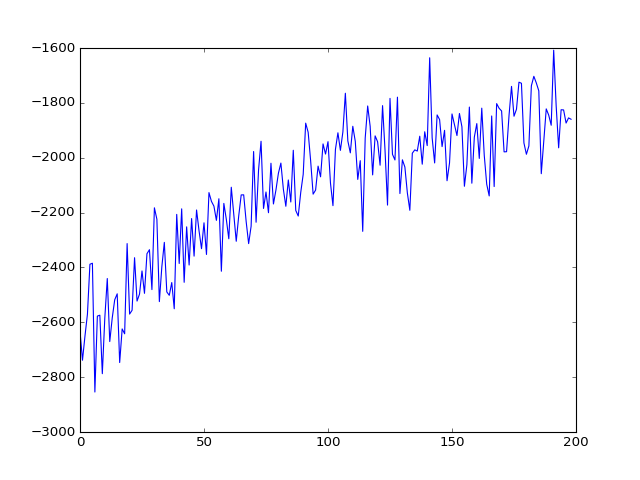

In [30]:
plt.plot(range(len(errors)), np.array(errors).reshape(-1, 1))